In [1]:
from fastai.text import *
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
from sklearn.utils import class_weight
from src.utils import plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
version = 'v1'
PATH = Path(f'/data/smith-monuments-sentiment/data')
LM_PATH = PATH/f'{version}/lm'
CLAS_PATH = PATH/f'{version}/clas'
ms = pd.read_csv(PATH/'Master_monuments_comments.csv')
ms = ms.dropna(subset=['investigator','sentiment'])
ms = ms.drop_duplicates(subset=['comment'])

In [4]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv').rename(columns={'label':'target', 'text':'data'}\
                                                  ).dropna()
df_val = pd.read_csv(CLAS_PATH/'test.csv').rename(columns={'label':'target', 'text':'data'}\
                                                 ).dropna()
df_test = pd.read_csv(PATH/'master_test.csv', names=['target','data']\
                     ).dropna()

In [5]:
np.bincount(ms.sentiment)

array([  111, 10242,   453])

In [18]:
trn_counts = np.bincount(df_trn.target)
trn_perc = trn_counts/len(df_trn)*100
val_counts = np.bincount(df_val.target)
val_perc = val_counts/len(df_val)*100
test_counts = np.bincount(df_test.target)
test_perc = test_counts/len(df_test)*100
print(trn_counts, trn_perc, np.sum(trn_counts))
print(val_counts, val_perc, np.sum(val_counts))

[  99 9218  407] [ 1.0181  94.79638  4.18552] 9724
[  11 1025   45] [ 1.017576 94.819611  4.162812] 1081


Text(0.5, 1.0, 'RDUAA training and validation \n data distribution of sentiment')

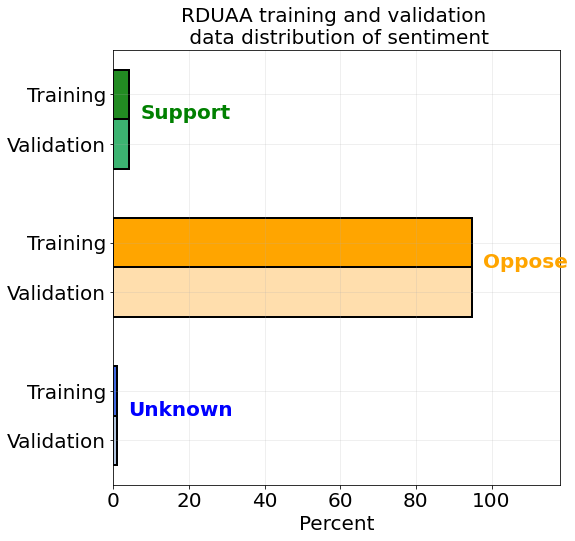

In [19]:
from matplotlib import lines
trn_colors = ['royalblue','orange','forestgreen']
val_colors = ['lightsteelblue','navajowhite','mediumseagreen']
labels = ['Unknown', 'Oppose', 'Support']
sublabels = ['Validation','Training', 'Validation','Training', 'Validation', 'Training']
'''
title = 'Training Counts: Unk:%i,  Opp:%i,  Sup:%i \
        \n Validation Counts: Unk:%i,  Opp:%i,  Sup:%i \n'.expandtabs()\
                %(trn_counts[0],trn_counts[1],trn_counts[2],\
                  val_counts[0],val_counts[1],val_counts[2])
'''
ticks = []
indices = np.arange(3) 
width = np.min(np.diff(indices))/3
for a,b in zip(indices-width/2, indices+width/2):
    ticks.append(a)
    ticks.append(b)
f, ax = plt.subplots(1,1,figsize=(8,8))
ax.barh(indices+width/2., trn_perc, width, edgecolor='k',lw=2,color=trn_colors, label=labels)
ax.barh(indices-width/2., val_perc, width, edgecolor='k',lw=2,color=val_colors, label=labels)
ax.grid(alpha=0.25)
#ax.set_yticks(np.arange(3))
ax.set_yticks(ticks)
ax.set_yticklabels(sublabels, fontsize=14)
ax.set_xlabel('Percent', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlim(0, 118)
label_colors = ['blue', 'orange','green']
for i in range(len(trn_counts)):
    v = trn_perc[i]
    #print(v)
    #ax.text(v + 3, i-width/2, '%i'%trn_counts[i], color=trn_colors[i], fontsize=16,fontweight='bold')
    #ax.text(v + 3, i+width/2, '%i'%val_counts[i], color=val_colors[i], fontsize=16, fontweight='bold')
    ax.text(v+3, i, labels[i], color=label_colors[i],fontsize=20,fontweight='bold')
#xlab = ['%s'%i for i in np.arange(0,120,20)]
#xlab.append('')
#ax.set_xticklabels(xlab)
ax.set_title('RDUAA training and validation \n data distribution of sentiment', fontsize=20)

In [20]:
print(trn_counts,trn_perc)
print(val_counts, val_perc)

[  99 9218  407] [ 1.0181  94.79638  4.18552]
[  11 1025   45] [ 1.017576 94.819611  4.162812]


In [21]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),\
                      ('tfidf', TfidfTransformer()),\
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',\
                                                class_weight='balanced',\
                                                alpha=1e-6, max_iter=1000, \
                                                random_state=42)),])

In [22]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1),(1, 2)],\
               'tfidf__use_idf': (True, False),\
               'clf-svm__alpha': (1e-4, 1e-5, 1e-6), } 
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(df_trn.data, df_trn.target)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'clf-svm__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [23]:
predicted_svm = gs_clf_svm.predict(df_val.data)
np.mean(predicted_svm == df_val.target)
#predicted_svm = gs_clf_svm.predict(df_test.data)
#np.mean(predicted_svm == df_test.target)

0.9768732654949122

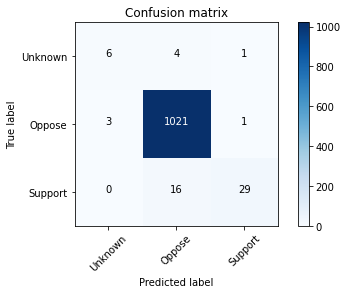

In [24]:
target_names =['Unknown','Oppose','Support']
cm = confusion_matrix(df_val.target, predicted_svm)
plot_confusion_matrix(cm, target_names)

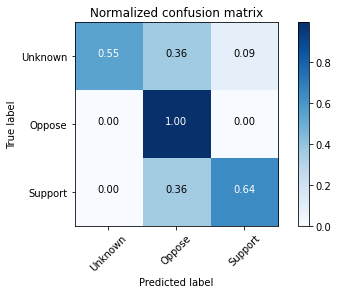

In [25]:
plot_confusion_matrix(cm, target_names, normalize=True)

In [26]:
classification_report(df_val.target,predicted_svm,\
                      target_names=target_names, output_dict=True)

{'Unknown': {'precision': 0.6666666666666666,
  'recall': 0.5454545454545454,
  'f1-score': 0.6,
  'support': 11},
 'Oppose': {'precision': 0.9807877041306436,
  'recall': 0.9960975609756098,
  'f1-score': 0.9883833494675701,
  'support': 1025},
 'Support': {'precision': 0.9354838709677419,
  'recall': 0.6444444444444445,
  'f1-score': 0.763157894736842,
  'support': 45},
 'accuracy': 0.9768732654949122,
 'macro avg': {'precision': 0.8609794139216841,
  'recall': 0.7286655169581998,
  'f1-score': 0.7838470814014707,
  'support': 1081},
 'weighted avg': {'precision': 0.9757053693439328,
  'recall': 0.9768732654949122,
  'f1-score': 0.9750555397478421,
  'support': 1081}}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


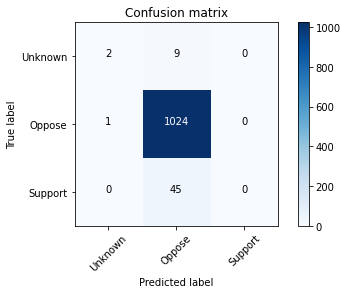

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_cnb_stemmed = Pipeline([('vect', stemmed_count_vect),\
                      ('tfidf', TfidfTransformer()),\
                      ('mnb', ComplementNB(fit_prior=True)),])

text_cnb_stemmed = text_cnb_stemmed.fit(df_trn.data, df_trn.target)
predicted_cnb_stemmed = text_cnb_stemmed.predict(df_val.data)
np.mean(predicted_cnb_stemmed == df_val.target)
cm = confusion_matrix(df_val.target, predicted_cnb_stemmed)
plot_confusion_matrix(cm, target_names)

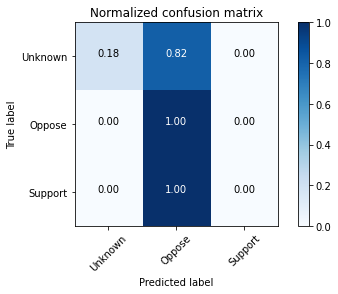

In [28]:
plot_confusion_matrix(cm, target_names, normalize=True)

In [29]:
target_names =['Unknown', 'Oppose','Support']
classification_report(df_val.target,predicted_cnb_stemmed,\
                      target_names=target_names, output_dict=True)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Unknown': {'precision': 0.6666666666666666,
  'recall': 0.18181818181818182,
  'f1-score': 0.28571428571428575,
  'support': 11},
 'Oppose': {'precision': 0.9499072356215214,
  'recall': 0.9990243902439024,
  'f1-score': 0.973846885401807,
  'support': 1025},
 'Support': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 45},
 'accuracy': 0.9491211840888066,
 'macro avg': {'precision': 0.538857967429396,
  'recall': 0.3936141906873614,
  'f1-score': 0.4198537237053643,
  'support': 1081},
 'weighted avg': {'precision': 0.9074821922714086,
  'recall': 0.9491211840888066,
  'f1-score': 0.9263051939682787,
  'support': 1081}}